# Diabetes Challenge

Your task today is to **analyze** the Kaggle "Pima Indians Diabetes Database" and to **predict** whether a patient has Diabetes or not.

## Task:
- Load the data from the database. The schema is called `diabetes`. To connect to the database you need to copy the `.env` file from the visualization or hands-on-ml repository into this repo. Explore the database, try to establish what the relationships between the tables are (1-1, 1-N, N-M). Explain to yourself and the group what data do you see and whether it makes sense. What JOINs are appropriate to use and why? 
- Use at least two different classification algorithms we have learned so far to predict Diabetes patients. 
- Discuss before you start with the modeling process which **evaluation metric** you choose and explain why.
- Implement a GridSearchCV or RandomizedSearchCV to tune the hyperparameters of your model.
- **Optional:** If you have time at the end, try to use sklearn's pipline module to encapsulate all the steps into a pipeline.

Don't forget to split your data in train and test set. And analyze your final model on the test data. It might also be necessary to scale your data in order to improve the performance of some of the models.


## Helpful links and advise:
- [sklearn documentation on hyperparameter tuning](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)
- It might be helpful to check some sources on how to deal with imbalanced data. 
    * [8 Tactics to Combat Imbalanced Classes](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)
    * [Random-Oversampling/Undersampling](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/)


# Data Description

## Context
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

## Acknowledgements
Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.

## About this dataset
The datasets consist of several medical predictor (independent) variables and one target (dependent) variable, Outcome. Independent variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on. For the outcome class value 1 is interpreted as "tested positive for diabetes".

|Column Name| Description|
|:------------|:------------|
|Pregnancies|Number of times pregnant|
|Glucose|Plasma glucose concentration a 2 hours in an oral glucose tolerance test|
|BloodPressure|Diastolic blood pressure (mm Hg)|
|SkinThickness|Triceps skin fold thickness (mm)|
|Insulin|2-Hour serum insulin (mu U/ml)|
|BMI|Body mass index (weight in kg/(height in m)^2)|
|DiabetesPedigreeFunction|  a function which scores likelihood of diabetes based on family history|
|Age| Age (years)|
|Outcome|Class variable (0 or 1) |

In [1]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import seaborn as sns

import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score

from sklearn.linear_model import LogisticRegression

from sklearn import set_config
set_config(transform_output="pandas")

# Set random seed 
RSEED = 42

warnings.filterwarnings("ignore")

In [3]:
# Read database string from .env file (no need to change anything)
load_dotenv()

DB_STRING = os.getenv('DB_STRING')

db = create_engine(DB_STRING)

In [9]:
# import the data into a pandas dataframe
query_string_1 = """

SET SCHEMA 'diabetes';


select p.pregnancies, p."Age" , p.bmi, po.diabetespedigreefunction pedigree_f, po.outcome, s.skinthickness, bm.insulin, bm.glucose, bm.bloodpressure  from patient p
left join pedigree_outcome po on po.patientid = p.id
left join skin s on s.patientid = p.id
left join blood_metrics bm on bm.patientid = p.id
where measurement_date = '2022-12-13'


"""
df = pd.read_sql(query_string_1, db)

#export the data to a csv-file
df.to_csv('df_diabetes.csv',index=False)
df

,pregnancies,Age,bmi,pedigree_f,outcome,skinthickness,insulin,glucose,bloodpressure
0,6,50,33.6,1,1,35,0,148,72
1,1,31,26.6,0,0,29,0,85,66
2,8,32,23.3,1,1,0,0,183,64
3,1,21,28.1,0,0,23,94,89,66
4,0,33,43.1,2,1,35,168,137,40
...,...,...,...,...,...,...,...,...,...
763,10,63,32.9,0,0,48,180,101,76
764,2,27,36.8,0,0,27,0,122,70
765,5,30,26.2,0,0,23,112,121,72
766,1,47,30.1,0,1,0,0,126,60


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pregnancies    768 non-null    int64  
 1   Age            768 non-null    int64  
 2   bmi            768 non-null    float64
 3   pedigree_f     768 non-null    int64  
 4   outcome        768 non-null    int64  
 5   skinthickness  768 non-null    int64  
 6   insulin        768 non-null    int64  
 7   glucose        768 non-null    int64  
 8   bloodpressure  768 non-null    int64  
dtypes: float64(1), int64(8)
memory usage: 54.1 KB


In [11]:
df.isnull().sum()

pregnancies      0
Age              0
bmi              0
pedigree_f       0
outcome          0
skinthickness    0
insulin          0
glucose          0
bloodpressure    0
dtype: int64

In [12]:
df.describe()

,pregnancies,Age,bmi,pedigree_f,outcome,skinthickness,insulin,glucose,bloodpressure
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,33.240885,31.992578,0.373698,0.348958,20.536458,79.799479,120.894531,69.105469
std,3.369578,11.760232,7.884160,0.510322,0.476951,15.952218,115.244002,31.972618,19.355807
min,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,24.000000,27.300000,0.000000,0.000000,0.000000,0.000000,99.000000,62.000000
50%,3.000000,29.000000,32.000000,0.000000,0.000000,23.000000,30.500000,117.000000,72.000000
75%,6.000000,41.000000,36.600000,1.000000,1.000000,32.000000,127.250000,140.250000,80.000000
max,17.000000,81.000000,67.100000,2.000000,1.000000,99.000000,846.000000,199.000000,122.000000


In [14]:
# Defining X and y

X = df.drop('outcome', axis=1)
y = df['outcome']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

# Check the shape of the data sets
print("X_train:", X_train.shape)  
print("y_train:", y_train.shape)  
print("X_test:", X_test.shape) 
print("y_test:", y_test.shape)   

X_train: (537, 8)
y_train: (537,)
X_test: (231, 8)
y_test: (231,)


Accuracy on train set: 0.76
Accuracy on test set: 0.77
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       150
           1       0.66      0.70      0.68        81

    accuracy                           0.77       231
   macro avg       0.74      0.75      0.75       231
weighted avg       0.77      0.77      0.77       231

--------------------------------------------------------------------------------


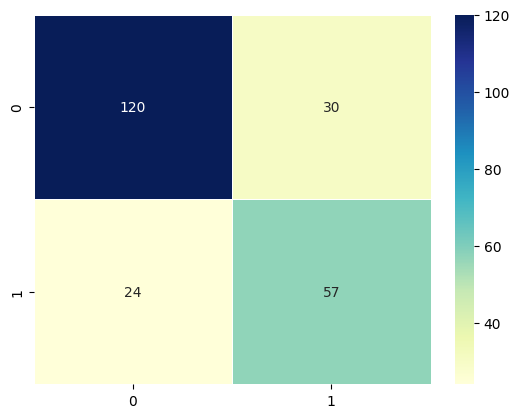

In [15]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")
log_reg.fit(X_train, y_train)

y_pred_train = log_reg.predict(X_train) 
y_pred = log_reg.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred), 2)) 
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);